# 3. Multicell population

In the last chapter we showed how to build, setup and run a full simulation from scratch of a network consisting of only one cell. This time we will build and simulate a network of hundreds of cells across multiple cell types. As we will see the procedure is much the same for building a heterogeneous network of hundreds of cells as it is for a single cell-network. 


In [1]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.bionet import rand_syn_locations
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.utils.create_environment import create_environment
from bmtk.analyzer.spike_trains import plot_raster
from bmtk.analyzer.compartment import plot_traces


<div class="alert alert-block alert-info">
<b>Tip</b>: When running the notebook for the first time it is recommend to clear out existing network, output, and components directories. Similarly if running the notebook multiple times the results of the previous build may affect the notebook if the SONATA files are not cleared out.
</div>

We can delete any existing SONATA network files either through the command-line:
```bash
  $ rm -r network/
```
or with the code below:

In [2]:
for f in glob.glob('network/*'):
    try:
        os.remove(f)
    except FileNotFoundError as fnfe:
        pass

<div class="alert alert-block alert-info">
<b>Tip</b>: There is a small amount of biologically relevant randomness built into the models and simulation, so everytime the notebook is run it is expected to get different results. However, should you want to match the same results with the "completed" version of the tutorials please uncomment out the rng seed below:
</div>

In [3]:
# np.random.seed(100)

## Building the Network Model

The first step is to determine what "Cell Types" models we want to use in our network, both in terms of the population make-up of the network, and if we are going to create new model files/parameters or incorporate existing ones. In SONATA and BioNet we have the option of incorporating NEURON hoc code and templates, as well as NeuroML files. Thus we could download our cell models from places like ModelDB or The Blue Brain Project. But for this tutorial we will stick to the [Allen Cell-Types Database](https://celltypes.brain-map.org/data).

We will want to use the Allen Cell-Types Feature Seach to select a certain number of cell types as we did in the [last tutorial](http://localhost:32001/notebooks/Ch2_single_cell/2.%20Single%20Cell.ipynb#Choosing-your-cell-models). We've already selected and downloaded them for you and placed them in the _components/_ directory. But if you want to choose your own cell models remember that since we are trying to simulate them as bio-realistic models that it has a morphology ("Reconstruction Type": "Full") and a Biophysical model (either "All-activate" or "Perisomatic").


##### Building Cells

<br>
<div>
  <img src="../images/builder_add_edges.png" width="500" align="left" style="margin-left:5px"/>    
</div>
<br clear="left">


For our example we will build a scaled down model of the mouse L4 primary visual cortex. For simplicity, we will use three excitatory cell types and one inhibitory type found in the mouse L4 of the Allen Cell-Types Database. To make the simulation efficient enough to run on a single processor in a reasonable amount of time we will only be modeling 75 biophysically detailed cells. To keep the ratio realistic we will want have 80% excitatory and 20% inhibitory. To place the cells in space, we will generate a cylinder of random coordinates (with _y_ being the vertical axis traversing the cortical layers and orthogonal to the pia mater).

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_coords(N, radius_min=0.0, radius_max=400.0):
    phi = 2.0 * np.pi * np.random.random([N])
    r = np.sqrt((radius_min**2 - radius_max**2) * np.random.random([N]) + radius_max**2)
    x = r * np.cos(phi)
    y = np.random.uniform(400.0, 500.0, size=N)
    z = r * np.sin(phi)
    return x, y, z

We call our network "l4" and start off by creating a subpopulation of "Scnn1a" type cells using the ```add_nodes()``` method:

In [5]:
from bmtk.builder.networks import NetworkBuilder

l4 = NetworkBuilder('l4')

x, y, z = get_coords(20)
assert(len(x) == len(y) == len(z) == 20)

l4.add_nodes(
    N=20,
    
    # Reserved SONATA keywords used during simulation
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    model_processing='aibs_perisomatic',
    dynamics_params='Scnn1a_485510712_params.json',
    morphology='Scnn1a_485510712_morphology.swc',
    
    # The x, y, z locations and orientations (in Euler angles) of each cell
    # Here, rotation around the pia-to-white-matter axis is randomized
    x=x,
    y=y,
    z=z,
    rotation_angle_xaxis=0,
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=20),
    rotation_angle_zaxis=np.full(20, 3.73),
    
    # Optional parameters
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
    model_name='Scnn1a',
    ei_type='e'
)


* By setting __N__=80 we are creating 80 individual Scnn1a type cells. 

* Properties **model_type**, **model_template**, and **model_processing** are directives to indicate to BMTK that we are building Allen-Cell Type Perisomatic model. Whereas **dynamics_params** and **morphology** refer to the electrophysiology and morphology files we downloaded from the Allen Cell-Types Databases.

* Next we set the coordinates and rotation angles for individual cells. Note that for **x**, **y**, **z**, **rotation_angle_axis**, and **rotation_angle_yaxis** we are passing in lists of size **N** so that each coordinate in unique to each cell.

* Finally we add optional attributes and metadata germane to our Visual L4 model. 


### [SIDE-TRACK]: Node-Type vs Node Properties
---
---
In SONATA, every node-type (or cell-type) will contain one or more individual nodes (or cells). Certain properties will have values that are identical and shared by every individual node, while other properties will have unique values for each cell. Whether or not a property is shared or unique will change how they are stored in the format.

In the BMTK NetworkBuilder, we can use strings, numbers, boolean and other non-list values to set a value as being "shared". It will also recognize Python tuples as being "shared" cell-type properties. Thus

```python
net.add_nodes(
    N=100,
    prop_A='shared',
    prop_B=2.71828,
    prop_C=('foo', 'bar')
    ...
```
All 100 individual cells will share the values of **prop_A**, **prop_B**, and **prop_C**.


If we want to assign unique values for each indivdiual node we should pass in either a list, array, generator or range value

```python
net.add_nodes(
    N=100,
    prop_D=['unique']*100,
    prop_B=np.random.uniform(0, 1.0, size=100),
    prop_C=range(0, 100)
    ...
```
---
---

We will continue on building the other nodes in much the same way by making additional calls to ```add_nodes()```

In [6]:
x, y, z = get_coords(20)
l4.add_nodes(
    # Rorb excitatory cells
    N=20,
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    dynamics_params='Rorb_486509958_params.json',
    morphology='Rorb_486509958_morphology.swc',
    model_processing='aibs_perisomatic',
    
    x=x, y=y, z=z,   
    rotation_angle_xaxis=0,
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=20),
    rotation_angle_zaxis=np.full(20, 4.40),
    
    model_name='Rorb', 
    ei_type='e',
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
)

x, y, z = get_coords(20)
l4.add_nodes(
    # Nr5a1 excitatory cells
    N=20,
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    dynamics_params='Nr5a1_485507735_params.json',
    morphology='Nr5a1_485507735_morphology.swc',
    model_processing='aibs_perisomatic',
    
    x=x, y=y, z=z,    
    rotation_angle_xaxis=0,
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=20),
    rotation_angle_zaxis=np.full(20, 4.04),
    
    model_name='Nr5a1', 
    ei_type='e',
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
)

x, y, z = get_coords(15)
l4.add_nodes(
    # Parvalbumin inhibitory cells, note these aren't assigned a tuning angle and ei=i
    N=15, 
    
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    dynamics_params='Pvalb_473862421_params.json',
    morphology='Pvalb_473862421_morphology.swc',
    model_processing='aibs_perisomatic',
    
    x=x, y=y, z=z, 
    rotation_angle_xaxis=0,
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=15),
    rotation_angle_zaxis=np.random.uniform(0.0, 2*np.pi, size=15),
    
    model_name='PValb',
    ei_type='i',
)

# l4.build()

**Note** that in our last call to ```add_nodes()``` we skipped the **tuning_angle** property (referring to the receptive field orientation tuning). For more information on **tuning_angle**, see [Tutorial 6](../Ch6_l4model/6.%20The%20L4%20Model.ipynb). This property is more relevant for excitatory L4 neurons than the less selective PValb neurons. BMTK and SONATA gives us the option to have different properities for different node-types even within the same network. 

__[SUGGESTION: Visualize the cells in VND. Maybe have them adjust the coordinates function and rotation angle]__
```python
l4.build()
l4.save_nodes(output_dir='network')
```

### Use VND to examine the cells in this model

Launch VND by typing `vnd` on the Linux command line.

In the Visual Neuronal Dynamics window select, select menu item  **File : Open File with Edges**
and choose the file `Ch3_multicells/config.l4.json`.

In the Main tab, in the Represenations pane:

In the list of representations, after loading, the   single, default selection is:

- Selected Neurons: all
- Coloring Method: Type
- Style: soma

With the "all" selection highlighted,
click "Representations:Create Rep" 
Then with this second represenation in the list selected, make these changes (in order)

- Selected Neurons: stride 5
- Style: morphology_draft


This will put a small selection of cell (every 5th cell)  into detailed morphology view.  This gives a sense of the sense of the system layout, but still allow manipulation of the system at usable frame rates.

Click on the top "all" (Type soma) selection in the Rperesentations pane list, then sleect **Display : Reset View** to view the whole system,


Explore the syanpse locations with zooming, rotation, and translation.


<div>
  <img src="../images/ch3_l4_stride_10_morpho_draft.png" width="805" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">





#### Building Connections

<br>
<div>
  <img src="../images/builder_add_edges.png" width="500" align="left" style="margin-left:5px"/>    
</div>
<br clear="left">

We can now start creating the rules for recurrent connections. Like with "Node Types" we can start by using the ```add_edges()``` method to create multiple "Edge Types". However, instead of passing in an integer for the total number of individual edges/synapses, ```add_edges()``` requires that we pass in at minimum:
1. A filter or list for the subset of nodes to use as _sources_/_pre-synaptic cells_
2. A filter or list for the subset of nodes to use as _targets_/_post-synaptic cells_.
3. A rule for how to many connections/edges between each source and target cell.

For example, imagine we want to create an Edge Type that connects all the excitatory type cells to other excitatory cells, where the number of connections is weighted according to their **tuning_angle** property. In this case the **connection_rule** is a function that takes in source and target cell objects (whose properties can be accessed like a regular Python dictionary) and should return an integer 0 or greater. When ```l4.build()``` is called BMTK will utilize this function for all valid source/target pairs of cells.  

In [7]:
def exc_exc_rule(source, target, max_syns):
    """Connection rule for exc-->exc neurons, should return an integer 0 or greater"""
    if source['node_id'] == target['node_id']:
        # prevent a cell from synapsing with itself
        return 0
    
    # calculate the distance between tuning angles and use it to choose
    # number of connections using a binomial distribution.
    src_tuning = source['tuning_angle']
    trg_tuning = target['tuning_angle']
    tuning_dist = np.abs((src_tuning - trg_tuning + 180) % 360 - 180)
    probs = 1.0 - (np.max((tuning_dist, 10.0)) / 180.0)
    return np.random.binomial(n=max_syns, p=probs)


conns = l4.add_edges(
    # filter for subpopulation or source and target nodes
    source=l4.nodes(ei_type='e'),
    target=l4.nodes(ei_type='e'),
    
    # connection function + any required parameters
    connection_rule=exc_exc_rule,
    connection_params={'max_syns': 15},
    
    # edge-type parameters
    syn_weight=3.0e-05,
    delay=2.0,
    dynamics_params='AMPA_ExcToExc.json',
    model_template='Exp2Syn',
)

The properties **syn_weight**, **delay**, **dynamics_params**, and **model_template** are all edge-type properties whose values are shared by every edge/synapse of this type. Like with nodes, we can add properties that are unique for every edge/synapse. But unlike the add_nodes() method, we can't just pass in list of size M to ```add_edges()``` (since we won't know how many individual edges the network contains until the connectivity matrix has been calculated).

Instead, to add unique properties to individual edges we will call the ```add_properties()``` method. For instance, we can place the synapse locations on the morphology and display them in VND, specified by _afferent_swc_id_ (referring to segments in the 3D morphological reconstruction of the SWC file) and _afferent_section_id_ (referring to the abstracted NEURON representation of the morphology, where sections are unbranched cables). The _afferent_section_pos_ and _afferent_swc_pos_ indicate relative position within the section. ```rand_syn_locations``` will assign these according to the _rule_params_. For a more extensive explanation of morphology parameters, see [3A. Morphology Representation](3A.%20Morphology%20Representation.ipynb).

In [8]:
from bmtk.builder.bionet import rand_syn_locations

conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['basal', 'apical'], 
        'distance_range': [30.0, 150.0],
        'morphology_dir': 'components/morphologies' 
    },
    dtypes=[int, float, int, float]
)

For other types of connections, since the source and/or target is an inhibitory cell with no **tuning_angle** property, we'll instead weigh the number of connections based on distance in the x/z plane. 
The parameter **distance_range** acts as a filter on the randomly selected locations, so setting it to [0.0, 1.0e+20] means essentially no spatial restrictions on where the synapses are placed.

In [9]:
def others_conn_rule(source, target, max_syns, max_distance=300.0, sigma=60.0):
    if source['node_id'] == target['node_id']:
        return 0
    
    dist = np.sqrt((source['x'] - target['x'])**2 + (source['z'] - target['z'])**2)
    if dist > max_distance:
        return 0
    
    prob = np.exp(-(dist/sigma)**2)      # Gaussian fall off with distance
    return np.random.binomial(n=max_syns, p=prob)

## Create e --> i connections
conns = l4.add_edges(
    source=l4.nodes(ei_type='e'),
    target=l4.nodes(ei_type='i'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 8},
    syn_weight=0.0006,
    delay=2.0,
    dynamics_params='AMPA_ExcToInh.json',
    model_template='Exp2Syn',
)
conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['somatic', 'basal'], 
        'distance_range': [0.0, 1.0e+20],
        'morphology_dir': 'components/morphologies' 
    },
    dtypes=[int, float, int, float]
)

## Create i --> e connections
conns = l4.add_edges(
    source=l4.nodes(ei_type='i'),
    target=l4.nodes(ei_type='e'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 4},
    syn_weight=0.07,
    delay=2.0,
    dynamics_params='GABA_InhToExc.json',
    model_template='Exp2Syn',
)
conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['somatic', 'basal', 'apical'], 
        'distance_range': [0.0, 50.0],
        'morphology_dir': 'components/morphologies' 
    },
    dtypes=[int, float, int, float]
)

## Create i --> i connections
conns = l4.add_edges(
    source=l4.nodes(ei_type='i'),
    target=l4.nodes(ei_type='i'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 4},
    syn_weight=0.00015,
    delay=2.0,
    dynamics_params='GABA_InhToInh.json',
    model_template='Exp2Syn',
)
conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['somatic', 'basal', 'apical'], 
        'distance_range': [0.0, 1.0e+20],
        'morphology_dir': 'components/morphologies' 
    },
    dtypes=[int, float, int, float]
)

Note that the **connection_rule** and **rule_params** functions have not yet been called. Only once we call the ```build()``` method will it utilize these functions to build the connectivity matrix. The ```build()``` process can take a bit of time to complete depending on the number of edges and the complexity of connection rules.


<br>
<div>
  <img src="../images/builder_complete_network.png" width="400" align="left" style="margin-left:5px"/>    
</div>


In [10]:
l4.build()
l4.save(output_dir='network')

### Show all the l4 population connections with VND 


From above VND session
 
 In the Connetions tab, set:
 
- Source: population == l4
- Target: population == l4
- Color: pin g 
- Style: simple_edges

then click "Create Connection rep".

Click on the top "all" (Type soma) selection in the Rperesentations pane list, then sleect **Display : Reset View** to view the whole system,


Explore the syanpse locations with zooming, rotation, and translation.


<div>
  <img src="../images/ch3_l4_edges.png" width="805" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">



### Show the l4 connections from a single cell in VND

In above session, hide all represenations but the first soma "all" representations.

If the VND session is getting slow, use **File : Reset VND** (or even quit and relaunch VND) then  **File : Open File with Edges**  `Ch3_multicells/config.l4.json`.

Follow the next steps to show the morphology for a single cell (node 1), set colors for different l4 cell types, then show the connections from node 1 to all the cells in l4.

In Main tab, Representations pane,
set:
- Selected Neurons: node_id ==1
- Coloring Method == Type
- Style: morphology

...then click **Create Rep**

set:
-  Selected Neurons: type == 100
- Coloring Method: cyan
- Style: soma

...then click **Create Rep**

set:
- Selected Neurons: type == 101
- Coloring Method: pink
- Style: soma

...then click **Create Rep**

set:
- Selected Neurons: type == 102
- Coloring Method: red
- Style: soma
...then click **Create Rep**

set:
- Selected Neurons: type == 103
- Coloring Method: purple
- Style: soma

...then click **Create Rep**

In Connections window,

set:
- Source: node_id == 1
- Target: population == l4
- Color: white
- Style: simple_edge
- Edge scale: 1

... then click **Create connection rep**.

<div>
  <img src="../images/ch3_l4_edges_node_1_to_colored_types.png" width="805" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">

Explore the syanpse locations with zooming, rotation, and translation.



### Adding Feedforward stimulus

At this point we could go ahead and start running simulations on our L4 network with stimuli such as current clamps, voltage clamps, or even extracellular electrodes. However, to make the model a bit more realistic we are going to want to stimulate it using feedforward synaptic input - just as the mouse visual cortex receives input from the lateral geniculate nucleus (LGN) in the thalamus. 

We will build another network to model the LGN, made up of "virtual" cells on a flat plane covering the visual space (for convenience, the coordinates here reference visual space rather than position within the brain area). The important thing is that the cells have **model_type**=virtual. We are also including other parameters **model_template** and **dynamics_params** to indicate the type of LGN cells (transient ON cells), but these options will be ignored until they are used with FilterNet later. 

In [11]:
def generate_coords_plane(ncells, size_x=240.0, size_y=120.0):
    xs = np.random.uniform(0.0, size_x, ncells)
    ys = np.random.uniform(0.0, size_y, ncells)
    return xs, ys
    

lgn = NetworkBuilder('lgn')

x, y = generate_coords_plane(100)
lgn.add_nodes(
    N=100,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tON',
    dynamics_params='tON_TF15.json',
    ei_type='e'
)

Next we need to connect the lgn cells to the l4 cells. To mimic the real LGN, we want to start by mapping the LGN plane to a topographically corresponding ellipse in the xz plane of our L4 model. For every lgn cell find all l4 cells that are within the ellipse, then select N excitatory cells and M inhibitory cells.

<br>
<div>
  <img src="../images/LGN_to_L4_conn_scheme.png" width="800" align="center" style="margin-left:5px"/>    
</div>
<br clear="left">

This would be very hard to accomplish with the previous **connection_rule** function that is called for every individual source/target pair. Instead we must use a different function signature - BMTK will pass into it 1 source cell and a list of dictionaries of all possible target cells. And the function will now return a list of integers for the number of synapses (including 0 entries) onto each individual target cell.

We just have to use the option **iterator**='one_to_all' (other options include 'all_to_one' and default option 'one_to_one').


In [12]:
def connect_lgn_cells(source, targets, max_targets, min_syns=1, max_syns=15, lgn_size=(240, 120),
                      l4_radius=400.0, ellipse=(100.0, 500.0)):
    # Map the lgn cells from the plane to the circle
    x, y = source['x'], source['y']
    x = x / lgn_size[0] - 0.5
    y = y / lgn_size[1] - 0.5
    src_x = x * np.sqrt(1.0 - (y**2/2.0)) * l4_radius
    src_y = y * np.sqrt(1.0 - (x**2/2.0)) * l4_radius

    # Find (the indices) of all the target cells that are within the given ellipse, if there are more than max_targets
    # then randomly choose them
    a, b = ellipse[0]**2, ellipse[1]**2
    dists = [(src_x-t['x'])**2/a + (src_y-t['y'])**2/b for t in targets]
    valid_targets = np.argwhere(np.array(dists) <= 1.0).flatten()
    if len(valid_targets) > max_targets:
        valid_targets = np.random.choice(valid_targets, size=max_targets, replace=False)

    # Create an array of all synapse count. Most targets with have 0 connection, except for the "valid_targets" which
    # will have between [min_syns, max_syns] number of connections.
    nsyns_arr = np.zeros(len(targets), dtype=int)
    for idx in valid_targets:
        nsyns_arr[idx] = np.random.randint(min_syns, max_syns)

    return nsyns_arr

In [13]:
conns = lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(ei_type='e'),
    connection_rule = connect_lgn_cells,
    connection_params = {'max_targets': 6},
    iterator='one_to_all',
    model_template='Exp2Syn',
    dynamics_params='AMPA_ExcToExc.json',
    delay=2.0,
    syn_weight=0.0019
)
conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['somatic', 'basal', 'apical'],
        'distance_range': [0.0, 1.0e+20],
        'morphology_dir': 'components/morphologies'
    },
    dtypes=[int, float, int, float]
)


conns = lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(ei_type='i'),
    connection_rule=connect_lgn_cells,
    connection_params={'max_targets': 12, 'ellipse': (400.0, 400.0)},
    iterator='one_to_all',
    model_template='Exp2Syn',
    dynamics_params='AMPA_ExcToInh.json',
    delay=2.0,
    syn_weight=0.003
)
conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['somatic', 'basal', 'apical'],
        'distance_range': [0.0, 1.0e+20],
        'morphology_dir': 'components/morphologies'
    },
    dtypes=[int, float, int, float]
)


lgn.build()
lgn.save(output_dir='network')

__[SUGGESTION: Show LGN to L4 connections with VND]__

#### Spikes for LGN inputs

Now that we have LGN virtual cells to synaptically connect and stimulate our L4 model, let's provide some spike trains for our LGN cells.

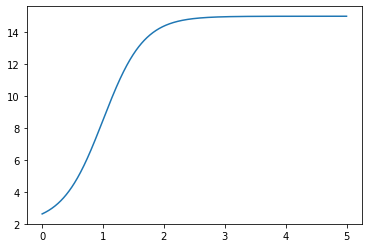

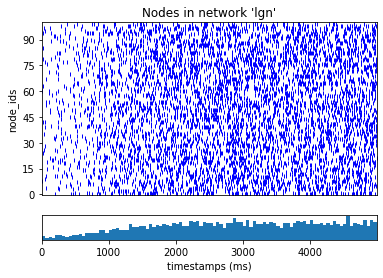

In [14]:
import matplotlib.pyplot as plt

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.analyzer.spike_trains import plot_raster

times = np.linspace(0.0, 5.0, 1000)
max_rate = 15.0
min_rate = 2.0
onset = 1.0
rates = (max_rate-min_rate)/(1.0 + np.exp(-(times-onset)*3.0)) + min_rate

psg = PoissonSpikeGenerator()
psg.add(
    node_ids='network/lgn_nodes.h5', 
    firing_rate=rates, 
    times=times,
    population='lgn'
)
psg.to_sonata('inputs/lgn_spikes.h5')

# plot the firing rates
plt.plot(times, rates)

_ = plot_raster(spikes_file='inputs/lgn_spikes.h5')

### Setting up the environment

The next step is to set up the directory where we will run our simulation, including the run_bionet.py script, configuration files, and components' files. This has already been setup for you, but if you were going to build the directory from scratch you can run either the following in the command line

```bash
  $ python -m bmtk.utils.create_environment                \
                 --config-file config.l4.json              \
                 --overwrite                               \
                 --network-dir network                     \
                 --output-dir output_syns                  \
                 --tstop 3000.0                            \
                 --dt 0.1                                  \
                 --report-vars v                           \
                 --spikes-inputs lgn:inputs/lgn_spikes.h5  \
                 --compile-mechanisms                      \
                 bionet .
```

or in the notebook:

In [15]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'bionet',
    base_dir='.',                      
    config_file='config.l4.json',   
    network_dir='network',             
    output_dir='output' ,       
    tstop=3000.0, dt=0.1,              
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
    report_vars=['v'],                 
    compile_mechanisms=True,           
    # overwrite=True,       
)

ERROR:root:Configuration file /home/student/Tutorials/bmtk_workshop_2022/Ch3_multicells/config.l4.json already exists, skipping. Please delete existing file, use a different name, or use overwrite=True.


/home/student/Tutorials/bmtk_workshop_2022/Ch3_multicells/components/mechanisms
Mod files: "modfiles/CaDynamics.mod" "modfiles/Ca_HVA.mod" "modfiles/Ca_LVA.mod" "modfiles/Ih.mod" "modfiles/Im.mod" "modfiles/Im_v2.mod" "modfiles/Kd.mod" "modfiles/K_P.mod" "modfiles/K_T.mod" "modfiles/Kv2like.mod" "modfiles/Kv3_1.mod" "modfiles/Nap.mod" "modfiles/NaTa.mod" "modfiles/NaTs.mod" "modfiles/NaV.mod" "modfiles/SK.mod" "modfiles/vecevent.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/student/miniconda3/envs/bmtk-py38/lib/python3.8/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /home/student/miniconda3/envs/bmtk-py38/lib/python3.8/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  ./mod_func.o ./CaDynamics.o ./Ca_HVA.o ./Ca_LVA.o ./Ih.o ./Im.o ./Im_v2.o ./Kd.o ./K_P.o ./K_T.o ./Kv2like.o ./Kv3_1

## Running the simulation

We are now ready to run the simulation of our L4 network with LGN stimulation. We can do this in console:

```bash
$ python run_bionet.py config.l4.json
```

or in the notebook, as shown below.

**Note: on a single core the following simulation can take a few minutes to run.** We can also run this on multiple cores from the terminal using MPI:

```bash
$ mpirun -np N nrniv -mpi -python run_bionet.py config.l4.json
```


In [16]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('config.l4.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2022-07-19 19:32:19,632 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2022-07-19 19:32:19,686 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-07-19 19:32:23,863 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-07-19 19:32:28,207 [INFO] Building virtual cell stimulations for lgn_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for lgn_spikes


2022-07-19 19:32:28,749 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.100 ms


2022-07-19 19:32:28,750 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-07-19 19:32:28,751 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-07-19 19:32:45,109 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2022-07-19 19:33:01,999 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2022-07-19 19:33:19,445 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2022-07-19 19:33:36,395 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2022-07-19 19:33:53,033 [INFO]     step:25000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms


2022-07-19 19:34:10,231 [INFO]     step:30000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms


2022-07-19 19:34:10,258 [INFO] Simulation completed in 101.5 seconds 


INFO:NEURONIOUtils:Simulation completed in 101.5 seconds 


/home/student/sources/bmtk/bmtk/analyzer/spike_trains.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_df = grp_df if grouped_df is None else grouped_df.append(grp_df, ignore_index=True)


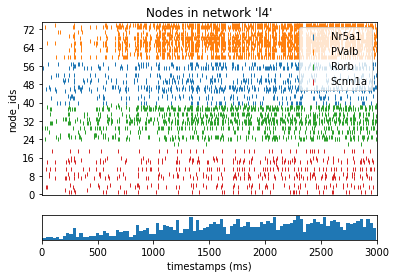

In [17]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.l4.json', group_by='model_name')

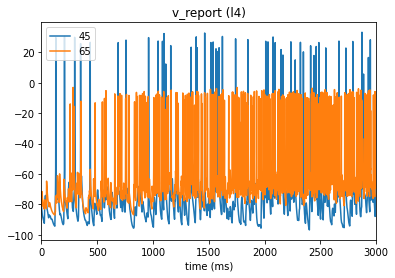

In [18]:
from bmtk.analyzer.compartment import plot_traces

# Plot the membrane potential trace
_ = plot_traces(config_file='config.l4.json', node_ids = [45, 65], report_name='v_report')

We can also get spiking statistics

In [19]:
from bmtk.analyzer.spike_trains import spike_statistics

spike_statistics(spikes_file='output/spikes.h5', simulation=sim, group_by='model_name')

/home/student/sources/bmtk/bmtk/utils/sonata/population.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ret_df = ret_df.append(self.get_group(grp_id).to_dataframe(), sort=False)
/home/student/sources/bmtk/bmtk/utils/sonata/population.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ret_df = ret_df.append(self.get_group(grp_id).to_dataframe(), sort=False)
/home/student/sources/bmtk/bmtk/simulator/core/simulator_network.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_nodes_df = all_nodes_df.append(node_pop_df)


firing_rate                  count                   isi  \
                  mean        std        mean        std       mean   
model_name                                                            
Nr5a1        12.266667  11.167832   36.800000  33.503495  41.403785   
PValb        48.755556  19.830419  146.266667  59.491256  25.536129   
Rorb         16.850000  15.925071   50.550000  47.775214  62.371708   
Scnn1a        7.433333   7.278182   22.300000  21.834545  47.021285   

                        
                   std  
model_name              
Nr5a1        44.427266  
PValb        23.608964  
Rorb        102.232589  
Scnn1a       41.880203

### Show spike activity animation in VND

Launch VND by typing `vnd` on the Linux command line.

In the Visual Neuronal Dynamics window select, select menu item  **File : Open File with Edges**
and choose the file `Ch3_multicells/config.l4.json`.

In the Main tab, in the Represenations pane:

In the list of representations, after loading, the   single, default selection is:

- Selected Neurons: all
- Coloring Method: Type
- Style: soma

Select menu item  **File : Add File with Spikes** and choose `Ch3_multicells/output/spikes.h5`

In the Activity window, set

- Population:l4

Click **Update Selection**

set:
- Color: blue
- Sphere Scale: 10
- Sphere Resolution: 5
- Step: 5
- Time window: 10

If no sturctures are showing, you may need to select **Display : Reset View**.  (Or even, in the Main tab Representations pane,select the soma, "all" representation, then select **Display : Reset View**.)

Drag the time slider left and right ,  drag it back to the far left, then press the right-pointing play button to play through the series of spikes.  Change speed with the Speed slider.


Direct link to <a href="http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch3-spikes-soma-titled-persp.mp4"> l4 spikes (tilted perspective) video </a>


<video controls>
  <source src="http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch3-spikes-soma-titled-persp.mp4" type="video/mp4">
  This browser does not display the video tag.
</video>
    </div>
<br clear="left">



### VND l4 spike activity movie with morphology

Another view of the spike data can be generated using cell morphology.  With the currrent version of VND, this takes about 20 minutes to generate, much too slow to get a sense of the animation when viewed live.  Here is a screencast of a VND session showing this animation sped up 45x. 

Direct link to <a href="http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch3-spikes-l4-morpho-x45.mp4"> ch3-spikes-morpho-x45 mp4 video </a>


<video controls>
  <source src="http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch3-spikes-l4-morpho-x45.mp4" type="video/mp4">
  This browser does not display the video tag.
</video>
    </div>
<br clear="left">








## Up Next

We have shown how to build and simulate a toy model of the mouse cortex using multi-compartment biophysically realistic cell models. But as mentioned in the introduction bmtk, SONATA, and vnd can work across multiple levels of resolutions. In the next chapter we will show how using the same API with only some minor adjustments we can convert or rebuild the same model using point neuron and even population level models.


[**Proceed to Chapter 4**](../Ch4_pointnet/4.%20Multipopulation%20GLIF%20model.ipynb)

Continue below if you would like to try adding a less computationally-intensive surround consisting of point LIF neurons in the same model as our core of biophysically detailed neurons. In general, this could be useful if you need to simulate many neurons at a low level of detail interacting with some neurons of interest at a high level of detail.

## [OPTIONAL] Adding Surrounding Neurons

We have a core set of 75 neurons we are interested in simulating and analyzing. They receive inputs from the LGN and they are recurrently connected, but don't have any neighboring neurons. This can be unrealistic and could produce unintended boundary artifacts. We could place additional biophysically detailed neurons on the periphery of our L4 column - but this would make the model more complex than it has to be, increasing the time and processing we will need to run it.

Instead, we can add very simple integrate-and-fire neurons to our network. These can mimic the interaction of surrounding neuronal activity - without adding too much complexity in terms of fitting the weights and the computational requirements to run the model.

<br>
<div>
  <img src="../images/l4_with_periphery.png" width="800" align="left" style="margin-left:5px"/>    
</div>

We could go back and rebuild the l4 network with these intfire neurons, but for easy of use we'll just create it as a separate network and connect it up in the config.

We'll call our network "lif" for leaky integrate-and-fire. We'll add a population of excitatory and inhibitory lif's but noting the following:
* **model_type** is now set to "point_neuron" 
* There is no need for **morphology** or **model_processing**, since these are simple point-neuron models that don't have any associated morphology.
* In **model_template** we'll set it so they are using NEURON's built-in [IntFire1 type cells](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#IntFire1).

In [20]:
lif = NetworkBuilder('lif')

# place neurons on outer ring
x, y, z = get_coords(80, radius_min=400.0, radius_max=800.0)
lif.add_nodes(
    N=80, 
    x=x, y=y, z=z,
    model_type='point_neuron',
    model_template='nrn:IntFire1',
    dynamics_params='IntFire1_exc_1.json',
    model_name='LIF_exc', 
    ei_type='e',
)

x, y, z = get_coords(20, radius_min=400.0, radius_max=800.0)
lif.add_nodes(
    N=20, 
    x=x, y=y, z=z,
    model_type='point_neuron',
    model_template='nrn:IntFire1',
    dynamics_params='IntFire1_inh_1.json',
    model_name='LIF_inh', 
    ei_type='i',
)


Now we will connect our LIF neurons to our L4 neurons. Previously we were using the Builder's ```add_properties()``` to explicity store the target synaptic locations in the _edges.h5_ file. This time we will store the **target_sections** and **distance_range** as edge-type properties. BMTK has a special feature that when it sees these two arguments in the edge-type properties it will use them to randomly create synapses during the simulation processes. This will add a bit of randomness when we run the simulations.

In [21]:
lif.add_edges(
    source=lif.nodes(ei_type='e'), target=l4.nodes(ei_type='e'),
    connection_rule=8,
    syn_weight=0.015,
    delay=2.0,
    distance_range=[30.0, 150.0],
    target_sections=['somatic', 'basal', 'apical'],
    dynamics_params='AMPA_ExcToExc.json',
    model_template='Exp2Syn'
)

lif.add_edges(
    source=lif.nodes(ei_type='e'), target=l4.nodes(ei_type='i'),
    connection_rule=5,
    syn_weight=0.015,
    delay=2.0,
    distance_range=[30.0, 150.0],
    target_sections=['somatic', 'basal'],
    dynamics_params='AMPA_ExcToInh.json',
    model_template='Exp2Syn'
)

lif.add_edges(
    source=lif.nodes(ei_type='i'), target=l4.nodes(ei_type='e'),
    connection_rule=5,
    syn_weight=0.085,
    delay=2.0,
    distance_range=[0.0, 50.0],
    target_sections=['somatic', 'basal', 'apical'],
    dynamics_params='GABA_InhToExc.json',
    model_template='Exp2Syn'
)

lif.add_edges(
    source=lif.nodes(ei_type='i'), target=l4.nodes(ei_type='i'),
    connection_rule=5,
    syn_weight=0.085,
    delay=2.0,
    distance_range=[0.0, 1e+20],
    target_sections=['somatic', 'basal'],
    dynamics_params='GABA_InhToInh.json',
    model_template='Exp2Syn'
)


Now we connect our L4 cells to our LIFs, as-well-as our LIFs to each other. Since we are connecting to neurons that are just a point in space it doesn't make sense to specify the synaptic locations:

In [22]:
# Connect L4 --> LIFs
lif.add_edges(
    source=l4.nodes(ei_type='e'), target=lif.nodes(),
    connection_rule=lambda *_: np.random.randint(0, 12),
    syn_weight=0.015,
    delay=2.0,
    dynamics_params='instantaneousExc.json',
    model_template='Exp2Syn'
)

lif.add_edges(
    source=l4.nodes(ei_type='i'), target=lif.nodes(),
    connection_rule=lambda *_: np.random.randint(0, 12),
    syn_weight=0.05,
    delay=2.0,
    dynamics_params='instantaneousInh.json',
    model_template='Exp2Syn'
)

# Connect LIFs --> LIFS
lif.add_edges(
    source=lif.nodes(ei_type='e'), target=lif.nodes(),
    connection_rule=lambda *_: np.random.randint(0, 12),
    syn_weight=0.005,
    delay=2.0,
    dynamics_params='instantaneousExc.json',
    model_template='Exp2Syn'
)

lif.add_edges(
    source=lif.nodes(ei_type='i'), target=lif.nodes(),
    connection_rule=lambda *_: np.random.randint(0, 12),
    syn_weight=0.020,
    delay=2.0,
    dynamics_params='instantaneousInh.json',
    model_template='Exp2Syn'
)


In [23]:
lif.build()
lif.save(output_dir='network')

### Visualize the l4 and LIF system wtih VND

Launch VND by typing `vnd` on the Linux command line.

In the Visual Neuronal Dynamics window select, select menu item  **File : Open File with Edges**
and choose the file `Ch3_multicells/config.l4_with_lifs.json`.

In the Main tab, in the Represenations pane:

In the list of representations, after loading, the   single, default selection is:

- Selected Neurons: population = lif
- Coloring Method: Type
- Style: soma

In the Representations window, click **Create rep** then set

- Selected Neurons: population = l4
- Coloring Method: Type
- Style: morphology


Select the top "population == lif" rerpresentation in the list, then select **Display :: Reset View"

We will reposition the scene with the morphology view hidden, find a good position, then show the morphology representation.

Select the "population = l4" representation, click Show/Hide to hide. The selection list text should appear in red.

Click **Display :: Perspective"**, then reposition the scene using the mouse.

When at desired locatiojn, be sure the "population = l4" representation is selected, then click Show/Hide to show.



<div>
  <img src="../images/l4-morpho-lifs-soma-tach.png" width="805" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">



Building the LIFs network will create 4 sets of SONATA network files:
1. We have the **LIF nodes**
2. The SONATA network files for the **LIF --> L4** connections.
3. The SONATA network files for the **L4 --> LIF** connections.
4. The SONATA network files for the **LIF --> LIF** connnections.

(note: There are options to store all of them in one single file - but by default, and in our experience for ease of use during the simulation, the BMTK Builder will split them across multiple files)

We could call ```bmtk.utils.create_environment``` like we do above to create a new SONATA configuration file. Or alternatively we can just copy the previous config and update the "network" section to include the newly created SONATA network files, like below.

<br>
<div>
  <img src="../images/ch3_circuit_config_w_lifs_highlighted.png" width="800" align="left" style="margin-left:5px"/>    
</div>
<br clear="left">

We call our new configuration file *config.l4_with_lifs.json*.

The three sets of connections shown in VND.  The l4 to l4 connections are in blue, lif to l4 in orange, and l4 to lif in silver.

<div>
  <img src="../images/ch3-connection-sets.png" width="805" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">

We can now run our model as before. **Note: on a single core the following simulation can take a few minutes to run.**

In [24]:
# Will reset BioNet and the NEURON simulator. Required if we want
# to run the simulator multiple times in the same notebook.
bionet.reset()

In [25]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('config.l4_with_lifs.json')

conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2022-07-19 19:34:11,473 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2022-07-19 19:34:11,533 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-07-19 19:34:18,425 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-07-19 19:34:29,117 [INFO] Building virtual cell stimulations for lgn_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for lgn_spikes


2022-07-19 19:34:29,666 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.100 ms


2022-07-19 19:34:29,667 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-07-19 19:34:29,669 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-07-19 19:35:17,659 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2022-07-19 19:36:07,435 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2022-07-19 19:37:08,359 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2022-07-19 19:38:15,899 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2022-07-19 19:39:25,471 [INFO]     step:25000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms


2022-07-19 19:41:16,148 [INFO]     step:30000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms


2022-07-19 19:41:16,183 [INFO] Simulation completed in 6.0 minutes, 46.52 seconds 


INFO:NEURONIOUtils:Simulation completed in 6.0 minutes, 46.52 seconds 



This time, when plotting the spiking activity, we have to indicate the population that we wish to show with the _population_ option:

/home/student/sources/bmtk/bmtk/analyzer/spike_trains.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_df = grp_df if grouped_df is None else grouped_df.append(grp_df, ignore_index=True)


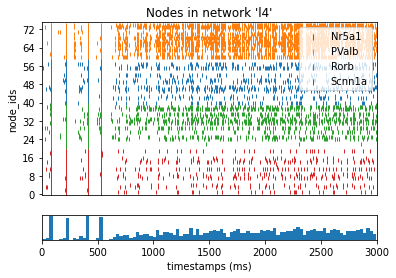

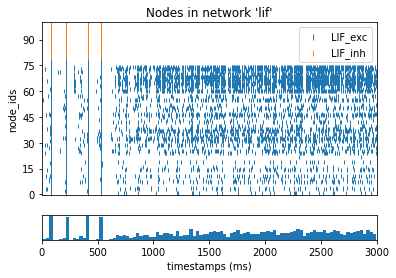

In [26]:
_ = plot_raster(config_file='config.l4_with_lifs.json', population='l4', group_by='model_name')
_ = plot_raster(config_file='config.l4_with_lifs.json', population='lif', group_by='model_name')

### Show spike activity animation with LIFS animation

Launch VND by typing `vnd` on the Linux command line.

In the Visual Neuronal Dynamics window select, select menu item  **File : Open File with Edges**
and choose the file `Ch3_multicells/config.l4_with_lifs.json`.

In the Main tab, in the Represenations pane:

In the list of representations, after loading, change the to single, default selection to:

- Selected Neurons: population == 14
- Coloring Method: red
- Style: soma

Click **Create Represenation**

- Selected Neurons: population == 1ifs
- Coloring Method: green
- Style: soma

Select menu item  **File : Add File with Spikes** and choose `Ch3_multicells/output_with_lifs/spikes.h5`


In the Activity tab, set

- Population: l4

Click **Update Selection**

set:
- Color: blue
- Sphere Scale: 10
- Sphere Resolution: 5
- Step: 1
- Time window: 10

If no sturctures are showing, you may need to select **Display : Reset View**.  (Or even, in the Main tab Representations pane,select the soma, "all" representation, then select **Display : Reset View**.)

Press the right-pointing play button to animate the activity.  Other options: Drag the time slider left and right. Change speed with the Speed slider.

Now show the same for population lif:

In the Activity tab, set

- Population: lif

Press the right-pointing play button to animate the LIF activity.





Direct link to <a href="http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch3-with-lifs-spikes-of-l4.mp4"> l4 spikes,  with-lifs model,  mp4 video </a>

Direct link to <a href="http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch3-with-lifs-spikes-of-lif.mp4"> lif spikes, with-lifs model, mp4 video </a>

## (OPTIONAL) Deep Dive into SONATA Nodes and Edges Format

Now that we have shown how to build multi-cells heterogeneous network models; let's take a look at the SONATA nodes and edges files, and learn about how they are formatted, in case you want to implement the SONATA format yourself.

#### nodes

If we open up one of our _nodes.h5_ files using a tool like HDFView or ViTables we can see they all have a format like the following:

<br>
<div>
  <img src="../images/nodes_sonata_layout.png" width="950" align="left" style="margin-left:10px"/>    
</div>
<br clear="left">

* We see it always starts with the path /nodes/$<$population$>$/, where $<$population$>$ is the name we give to the set of nodes.


* All individual nodes/cell are assigned a unique _node_id_ within the population. These node_ids are not global and the other populations will almost surely have overlapping ids, hence it's important each node is uniquely recognized by ($<$population$>$, node_id). 


* Each node has an assigned _node_type_id_ which point to the global Node-Type (Cell Type) properties. The node_type properties are saved in a easy to read and modify _node_types.csv_ table like the following:

<br>
<div>
  <img src="../images/node_types_sonata_layout.png" width="820" align="left" style="margin-left:30px"/>    
</div>
<br clear="left">

* Each individual node/cell may have additional properties; these are stored in an HDF5 subgroup.

In the simplest case we can think of the each node as having the following format as they relate to their Node Type and individual node properties:

<br>
<div>
  <img src="../images/sonata_hdf5_format_no_groups.png" width="800" align="left" style="margin-left:5px"/>    
</div>
<br clear="left">

The only issue is that it's possible to have different neuronal models that require different parameters. Sometimes a parameter will have different data types and meanings: ex. $\alpha$ may be unsigned integers for one group of neurons, while for another group of neurons the $\alpha$ parameter is expecting a float. This is where the _group_id_ and _group_index_ columns come in, allowing us to assign individual neurons to only their appropriate set of parameters:

<br>
<div>
  <img src="../images/sonata_hdf5_format_w_groups.png" width="800" align="left" style="margin-left:5px"/>    
</div>
<br clear="left">


#### Edges

![](../images/edges_sonata_layout.png)

We can see that the edges file looks very similar to the nodes, with some minor distinctions.

* The edges inside the HDF5 start with path /edges/$<$population$>$, where $<$population$>$ is any arbitary name we give these set of edges (The NetworkBuilder will infer a name unless explicity stated).


* Instead of _edge_id_, each edge is identified by the _node_id_ of the source cell (_source_node_id_ table) and target cell (_target_node_id_ table).
  * For any two cells A and B, the connection(s) A --> B may occur 0, 1, or more times. The format is a multigraph structure.
  * Both _source_node_id_ and _target_node_id_ have attributes "node_population" which is the name of the population of nodes for the source and for the target neurons. All source nodes must belong to the same population, and similarly all target nodes must also belong to the same population (although the two may be different).


* The format includes an optional group called _indices_ which contains lookup tables for determining all indices of any arbitary source_node_id, target_node_id, or edge_type_id in $O(1)$ time.


* Individual edge parameters are grouped as described above with nodes, but called _edge_group_id_ and _edge_group_index_ instead of _node_group_id_ and _node_group_index_.